Нарисуем данные коммерческого предприятия для анализа, на случай если дали задачу SQL без данных

Нарисовать нужно продажи, то есть 

- Время продажи
- Клиента
- Товар
- Цену
- Скидку
- Признак постоянности клиента (регистрация в программе лояльности)

In [414]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize' : (12, 5)}, font='verdana')
plt.style.use('dark_background')

Соберем интервал дат будущей таблицы

In [362]:
date_start = '2024-05-01' # Начало временного диапазона
date_end = '2024-12-31'   # Конец временного дипазона

In [363]:
df = pd.DataFrame({'date' : pd.date_range(date_start, date_end)})
df.head(3)

,date
0,2024-05-01
1,2024-05-02
2,2024-05-03


Считаем, что в одну дату у нас больше одного заказа и количество заказов разное в разные дни.

Наберем число заказов в день через логнормальное распределение распределение - получим выбросы в данных

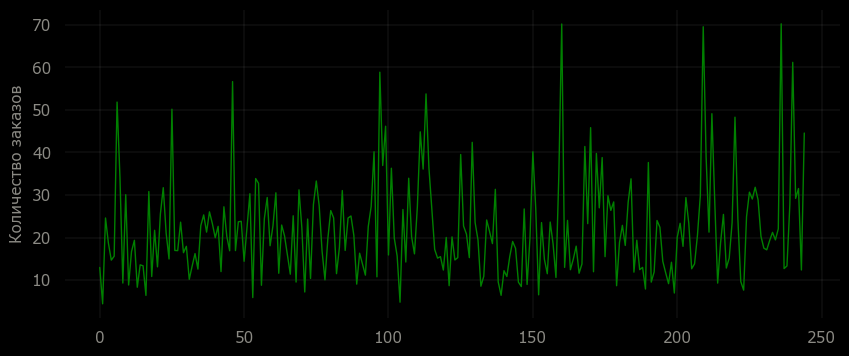

In [364]:
plt.figure(figsize=(10,4))

df['cnt'] = pd.Series(np.random.lognormal(3, 0.5, size = len(df)))
sns.lineplot(x = df.cnt.index, y = df.cnt.values, color='green',linewidth=1)

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

У нас есть число заказов для каждой даты

In [365]:
df.head(3)

,date,cnt
0,2024-05-01,12.954442
1,2024-05-02,4.407261
2,2024-05-03,24.589367


Разные заказы с одной датой - это записи с разными id покупателей и с одной и той же датой. 

Каждую дату нужно повторить столько раз, сколько заказов ей соответствует.

In [366]:
df.cnt = df.cnt.round(0).astype(int) # Округляем число заказов

Превратим дату в список из одного элемента - даты, умножим список на число заказов, получив список длиной в число заказов, суммируем все списки, дописав их один за другим и превратим все в датафрейм

In [367]:
dt = pd.DataFrame({'date':(df.date.apply(lambda x : [x]) * df.cnt).sum()})
df = dt


In [368]:
df

,date
0,2024-05-01
1,2024-05-01
2,2024-05-01
3,2024-05-01
4,2024-05-01
...,...
5414,2024-12-31
5415,2024-12-31
5416,2024-12-31
5417,2024-12-31


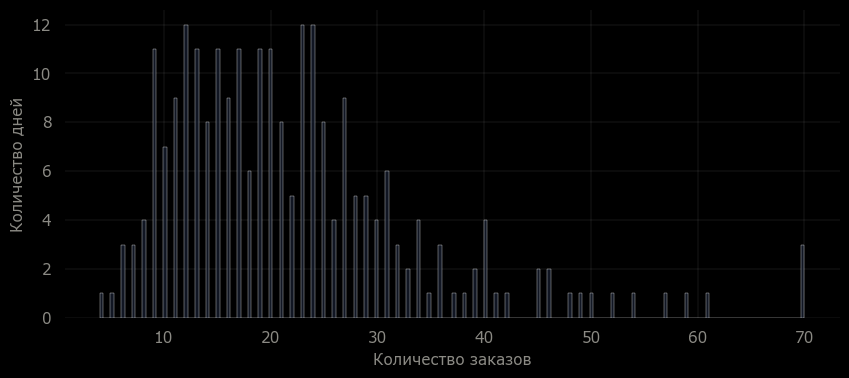

In [369]:
plt.figure(figsize=(10,4))

sns.histplot(df.date.value_counts(), bins = 200, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество дней", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

Теперь дорисуем заказам время. Наберем все секунды в сутках, затем случайным сэмплом выберем из них по нужному числу записей для каждой даты.

Отфильтруем время до 8 утра и после 11 вечера, типа в это время магазин закрыт

In [370]:
tm = pd.date_range('2020-01-01','2020-01-02', freq = 's').time
tm = pd.Series(tm)
tm = tm[(tm.values > datetime.time(8, 0, 0)) & (tm.values < datetime.time(23, 0, 0))]
tm.head(3)

28801    08:00:01
28802    08:00:02
28803    08:00:03
dtype: object

In [371]:
dt = pd.DataFrame(df.date.value_counts()).reset_index()
dt.head(3)

,date,count
0,2024-10-08,70
1,2024-11-26,70
2,2024-12-23,70


В Count у нас число секундных интревалов, которые слуйным образом нам надо набрать

In [372]:
t = []

lst = [tm.sample(dt['count'][i],replace = False) for i in range(len(dt))] # Собираем список списков (набор времен заказа для каждой даты)
lst = pd.Series([item for sublist in lst for item in sublist])            # Превращаем список списков в один сплошной список времен
lst

0       08:19:01
1       09:37:32
2       14:39:51
3       09:26:17
4       14:06:37
          ...   
5414    15:23:08
5415    09:06:41
5416    12:37:21
5417    15:57:04
5418    15:01:21
Length: 5419, dtype: object

In [373]:
df['time'] = lst
df.head(3)


,date,time
0,2024-05-01,08:19:01
1,2024-05-01,09:37:32
2,2024-05-01,14:39:51


In [374]:
df['datetime'] = pd.to_datetime(df['date'].astype(str) + ' ' + df['time'].astype(str)) # Соберем дату и время в одно поле

In [375]:
df = df['datetime'].to_frame()
df.head(3)

,datetime
0,2024-05-01 08:19:01
1,2024-05-01 09:37:32
2,2024-05-01 14:39:51


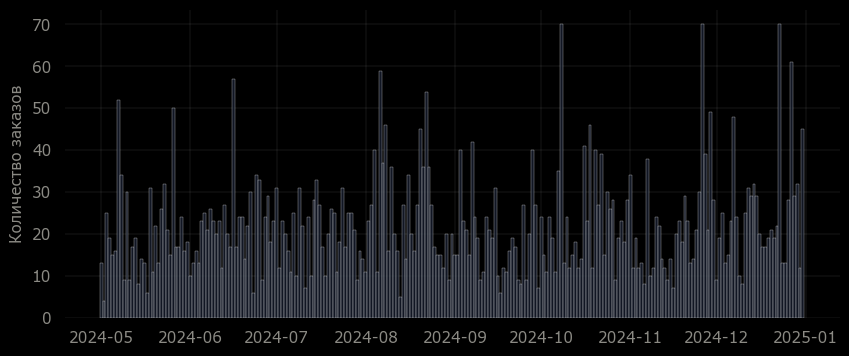

In [376]:
plt.figure(figsize=(10,4))

sns.histplot(df.datetime.dt.date, bins = 200, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

Один заказ - один пользователь, но в заказе может быть больше одного товара, продажа каждого товара - это запись с одним datetime, одним order_id и одним товаром

Нарисуем id заказов к каждой записи

In [377]:
df['order_id'] = range(2783590-len(df), 2783590) # возьмем любой диапазон лишь бы разница была в длину df и число цифр на границах было бы одним и тем же (для красоты)
df.head(3)

,datetime,order_id
0,2024-05-01 08:19:01,2778171
1,2024-05-01 09:37:32,2778172
2,2024-05-01 14:39:51,2778173


Пользователей наберем случайно из равномерного распределения

Усложним задачу для реалистичности - не все покупают с регистрацией, то есть не каждый пользователь учтен. 

Пусть у нас будет только около половины зарегистрированных пользователей 

In [378]:
t = np.random.randint(10000, 100000, 2500)
t

array([56536, 17751, 57061, ..., 11468, 20926, 74319],
      shape=(2500,), dtype=int32)

Теперь эти записи с id пользователей нужно случайно разбавить пропусками - продажами непостоянным клиентам

In [379]:

t1 = pd.Series([[i] + [0]*pd.Series(np.random.randint(0,4,1))[0] for i in t]).sum()
len(t1)  # Главное чтобы итоговый массив получился длиннее чем df


6242

In [380]:
t1 = t1[:len(df)] # Подрежем список под длину df
len(t1)

5419

In [381]:
df['customer_id'] = t1
df

,datetime,order_id,customer_id
0,2024-05-01 08:19:01,2778171,56536
1,2024-05-01 09:37:32,2778172,0
2,2024-05-01 14:39:51,2778173,0
3,2024-05-01 09:26:17,2778174,17751
4,2024-05-01 14:06:37,2778175,0
...,...,...,...
5414,2024-12-31 15:23:08,2783585,0
5415,2024-12-31 09:06:41,2783586,0
5416,2024-12-31 12:37:21,2783587,0
5417,2024-12-31 15:57:04,2783588,83634


Мы решили, что в заказе может быть больше одного товара, продажа каждого товара - это запись с одним datetime, одним order_id и одним товаром, то есть нужно получить случайное число товаров в заказах и размножить строки в соответствии с этим количеством. Все по аналогии с числом заказов в один день.

Нарисуем товары

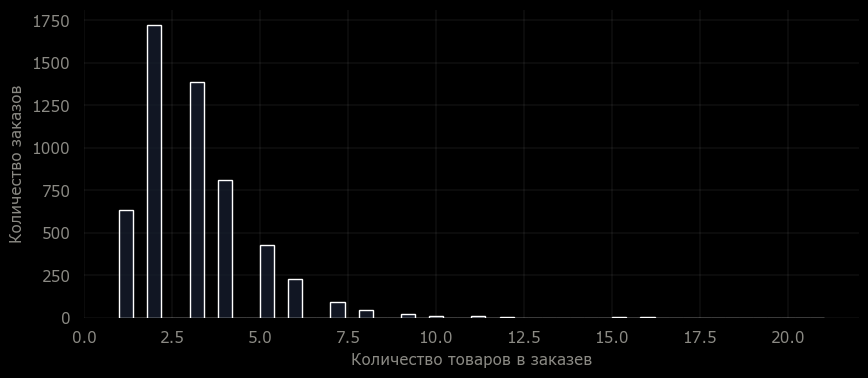

In [382]:
plt.figure(figsize=(10,4))

df['items_cnt'] = pd.Series(np.random.lognormal(1, 0.5, size = len(df)))
df.items_cnt = df.items_cnt.round(0).astype(int).replace(0,1)

sns.histplot(df.items_cnt, bins = 50, color='#171e2f')

plt.tick_params(axis='both', colors='#8b8a84')
plt.xlabel("", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.ylabel("Количество заказов", labelpad = 5, fontsize= 11,color='#8b8a84')
plt.xlabel("Количество товаров в заказев", labelpad = 5, fontsize= 11,color='#8b8a84')
for pos in ['right', 'top', 'bottom', 'left']: 
    plt.gca().spines[pos].set_visible(False)
plt.grid(color='darkgray', linestyle='-', linewidth=0.1)
plt.show()

In [383]:
dt = pd.DataFrame({'order_id':(df.order_id.apply(lambda x : [x]) * df.items_cnt).sum()})
dt

,order_id
0,2778171
1,2778171
2,2778172
3,2778173
4,2778173
...,...
16705,2783588
16706,2783589
16707,2783589
16708,2783589


In [384]:
dt = dt.merge(df, how = 'left', on = 'order_id')

In [385]:
df = dt[['datetime', 'order_id', 'customer_id']]
df

,datetime,order_id,customer_id
0,2024-05-01 08:19:01,2778171,56536
1,2024-05-01 08:19:01,2778171,56536
2,2024-05-01 09:37:32,2778172,0
3,2024-05-01 14:39:51,2778173,0
4,2024-05-01 14:39:51,2778173,0
...,...,...,...
16705,2024-12-31 15:57:04,2783588,83634
16706,2024-12-31 15:01:21,2783589,0
16707,2024-12-31 15:01:21,2783589,0
16708,2024-12-31 15:01:21,2783589,0


Нарисуем товары, пусть их будет 100 шт

In [386]:
items = pd.Series(['item_' + str(_) for _ in range (100)]).to_frame()
items.columns = ['item']
items['price'] = (np.random.uniform(10, 1000, size= 100)).round(1)
items

,item,price
0,item_0,877.0
1,item_1,705.2
2,item_2,617.9
3,item_3,393.2
4,item_4,601.8
...,...,...
95,item_95,454.5
96,item_96,321.6
97,item_97,243.6
98,item_98,513.5


Создадим популярность товаров

In [387]:
items['prob'] = np.random.poisson(10, 100) # Это вероятности покупки товаров
items

,item,price,prob
0,item_0,877.0,15
1,item_1,705.2,7
2,item_2,617.9,13
3,item_3,393.2,12
4,item_4,601.8,12
...,...,...,...
95,item_95,454.5,18
96,item_96,321.6,9
97,item_97,243.6,7
98,item_98,513.5,13


In [388]:
res = []
for i in range(100):
    res.append([items.item[i]]*items.prob[i])                   # Набираем полную группу событий
lst = pd.Series([item for sublist in res for item in sublist]).to_frame()  # Перевращаем список списков в простой список
lst.columns = ['test']
lst

,test
0,item_0
1,item_0
2,item_0
3,item_0
4,item_0
...,...
1043,item_99
1044,item_99
1045,item_99
1046,item_99


In [389]:
df['item'] = 1
df.head(3)

,datetime,order_id,customer_id,item
0,2024-05-01 08:19:01,2778171,56536,1
1,2024-05-01 08:19:01,2778171,56536,1
2,2024-05-01 09:37:32,2778172,0,1


Итак, у нас есть полная группа товаров с соответствующими вероятностями, теперь из нее мы будем сэмплить товар для каждой записи в df

In [390]:
for i in range(len(df)):
    df.item[i] = lst.test.sample(1, replace = True).values[0]
df

C:\Users\mail\AppData\Local\Temp\ipykernel_20248\3515476002.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df.item[i] = lst.test.sample(1, replace = True).values[0]
C:\Users\mail\AppData\Local\Temp\ipykernel_20248\3515476002.py:2: Setti

,datetime,order_id,customer_id,item
0,2024-05-01 08:19:01,2778171,56536,item_63
1,2024-05-01 08:19:01,2778171,56536,item_36
2,2024-05-01 09:37:32,2778172,0,item_5
3,2024-05-01 14:39:51,2778173,0,item_60
4,2024-05-01 14:39:51,2778173,0,item_18
...,...,...,...,...
16705,2024-12-31 15:57:04,2783588,83634,item_6
16706,2024-12-31 15:01:21,2783589,0,item_97
16707,2024-12-31 15:01:21,2783589,0,item_19
16708,2024-12-31 15:01:21,2783589,0,item_23


In [391]:
df = df.merge(items, how = 'left', on = 'item')
df = df[['datetime','order_id','customer_id', 'item', 'price']]
df

,datetime,order_id,customer_id,item,price
0,2024-05-01 08:19:01,2778171,56536,item_63,849.7
1,2024-05-01 08:19:01,2778171,56536,item_36,607.2
2,2024-05-01 09:37:32,2778172,0,item_5,549.0
3,2024-05-01 14:39:51,2778173,0,item_60,425.4
4,2024-05-01 14:39:51,2778173,0,item_18,78.6
...,...,...,...,...,...
16705,2024-12-31 15:57:04,2783588,83634,item_6,861.2
16706,2024-12-31 15:01:21,2783589,0,item_97,243.6
16707,2024-12-31 15:01:21,2783589,0,item_19,853.3
16708,2024-12-31 15:01:21,2783589,0,item_23,405.1


Добавим скидки для зарегистрированных клиентов (условно по карте)

In [411]:
df['discount'] = np.where(df['customer_id'] > 0, 0.2, 0)
df.head(3)

,datetime,order_id,customer_id,item,price,discount
0,2024-05-01 08:19:01,2778171,56536,item_63,849.7,0.2
1,2024-05-01 08:19:01,2778171,56536,item_36,607.2,0.2
2,2024-05-01 09:37:32,2778172,0,item_5,549.0,0.0


In [413]:
df

,datetime,order_id,customer_id,item,price,discount
0,2024-05-01 08:19:01,2778171,56536,item_63,849.7,0.2
1,2024-05-01 08:19:01,2778171,56536,item_36,607.2,0.2
2,2024-05-01 09:37:32,2778172,0,item_5,549.0,0.0
3,2024-05-01 14:39:51,2778173,0,item_60,425.4,0.0
4,2024-05-01 14:39:51,2778173,0,item_18,78.6,0.0
...,...,...,...,...,...,...
16705,2024-12-31 15:57:04,2783588,83634,item_6,861.2,0.2
16706,2024-12-31 15:01:21,2783589,0,item_97,243.6,0.0
16707,2024-12-31 15:01:21,2783589,0,item_19,853.3,0.0
16708,2024-12-31 15:01:21,2783589,0,item_23,405.1,0.0
